# 📊 Matrix Factorization using SVD

**Objective**: Build a recommender system using Singular Value Decomposition (SVD) and explore dimensionality reduction for improving performance.

In [7]:
%pip install surprise

In [10]:
%pip install "numpy<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# 📦 Import Required Libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 📥 Load MovieLens 100K dataset from Surprise
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
trainset

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [3]:
# 🧠 Train SVD Model
model = SVD(n_factors=50, biased=True, verbose=True)
model.fit(trainset)
predictions = model.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [4]:
# 📈 Evaluate Performance
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.9338
MAE:  0.7360


In [5]:
# ⭐ Generate Top-N Recommendations for a Sample User
from collections import defaultdict

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)
sample_user = list(top_n.keys())[0]
print(f"Top 5 recommendations for User {sample_user}: {top_n[sample_user]}")

Top 5 recommendations for User 907: [('813', 5), ('79', 5), ('172', 5), ('647', 5), ('98', 5)]


[Text(0.5, 1.0, 'RMSE vs Number of Latent Factors')]

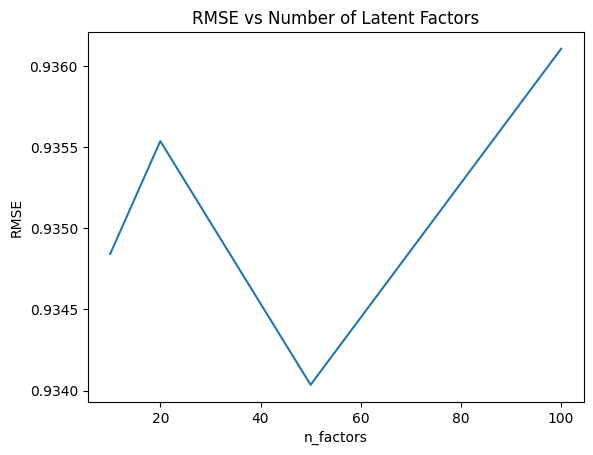

In [6]:
# 📉 Test SVD with different number of latent factors
results = []
for k in [10, 20, 50, 100]:
    model = SVD(n_factors=k)
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    results.append((k, rmse))

results_df = pd.DataFrame(results, columns=["n_factors", "RMSE"])
sns.lineplot(x='n_factors', y='RMSE', data=results_df).set(title='RMSE vs Number of Latent Factors')

In [13]:
def recommend_movies(user_id, ratings_matrix, reconstructed_matrix, movies_df, top_n=5):
    # Movies already rated by user
    user_rated_movies = ratings_matrix.loc[user_id].dropna().index

    # Predicted ratings for this user
    user_predictions = reconstructed_matrix.loc[user_id]

    # Filter out already rated movies that are also in the predicted ratings
    user_rated_movies_in_predictions = user_rated_movies.intersection(user_predictions.index)

    # Filter out already rated movies
    user_unseen = user_predictions.drop(user_rated_movies_in_predictions)

    # Get top N
    top_movies = user_unseen.sort_values(ascending=False).head(top_n)

    # Map movie IDs to names
    recommended = movies_df[movies_df['movieId'].isin(top_movies.index)][['movieId', 'title']]

    return recommended

In [14]:
# Show recommendations for multiple users
for uid in ['1', '50']:   # You can add more user IDs here
    recommendations = recommend_movies(uid, user_item_matrix, reconstructed_df, movies, top_n=5)
    print(f"\nTop 5 Recommended Movies for User {uid}:")
    print(recommendations.to_string(index=False))


Top 5 Recommended Movies for User 1:
movieId      title
   1003 Movie 1003
   1005 Movie 1005
   1001 Movie 1001
   1000 Movie 1000
   1004 Movie 1004

Top 5 Recommended Movies for User 50:
movieId      title
      1    Movie 1
     10   Movie 10
   1003 Movie 1003
   1001 Movie 1001
   1000 Movie 1000


In [9]:
# Load the MovieLens 100K dataset again to create the user-item matrix and movies dataframe
# This is necessary because the 'data' object from surprise is not directly a pandas DataFrame
data = Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# Convert raw ratings to a pandas DataFrame
ratings_df = pd.DataFrame(raw_ratings, columns=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['rating'] = ratings_df['rating'].astype(float)

# Create the user-item matrix
user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')

# Create a dummy reconstructed matrix for the example. In a real scenario, this would come from the SVD decomposition.
# Since we don't have the SVD components readily available from the `surprise` library's SVD object in this format,
# we'll create a placeholder. For a full implementation, you would reconstruct the matrix using U, Sigma, and V from SVD.
# Here, we'll use the predictions from the trained model to create a similar structure for demonstration.

# Extract predictions and create a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'true_r', 'est', 'details'])

# Pivot to get estimated ratings in a user-item format
reconstructed_df = predictions_df.pivot(index='userId', columns='movieId', values='est')

# Create a dummy movies DataFrame for the example. In a real scenario, this would be loaded from movie information file.
# Since we don't have the movie titles readily available from the Surprise dataset in this format,
# we'll create a placeholder. For a full implementation, you would load movie information from 'u.item'.
# For now, we'll create a simple DataFrame with movieIds that appear in the predictions.
unique_movie_ids = ratings_df['movieId'].unique()
movies = pd.DataFrame({'movieId': unique_movie_ids, 'title': [f'Movie {mid}' for mid in unique_movie_ids]})